In [1]:
import warnings

warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from wordcloud import WordCloud

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import cross_val_score

In [4]:
import nltk
from nltk import Text
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

# SMS Spam 분류

## Column 설명

- v1: label ['ham', 'spam']
- v2: raw text
- Unnamed: 2: 불필요한 데이터
- Unnamed: 3: 불필요한 데이터
- Unnamed: 4: 불필요한 데이터

In [5]:
df = pd.read_csv('csvs/spam.csv', encoding='latin-1')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


In [6]:
# drop ['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4']
df = df.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   v1      5572 non-null   object
 1   v2      5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


In [7]:
# v1 => label, v2 => 'text' 알아보기 쉽게 변경
df.columns = ['label', 'raw_text']
df.head()

,label,raw_text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [8]:
df[df['raw_text'].str.contains('&lt;#&gt;')]

,label,raw_text
44,ham,Great! I hope you like your man well endowed. ...
51,ham,"A gram usually runs like &lt;#&gt; , a half e..."
78,ham,Does not operate after &lt;#&gt; or what
177,ham,Turns out my friends are staying for the whole...
199,ham,"Found it, ENC &lt;#&gt; , where you at?"
...,...,...
5478,ham,No probably &lt;#&gt; %.
5504,ham,Wait . I will msg after &lt;#&gt; min.
5513,ham,Yes. Please leave at &lt;#&gt; . So that at ...
5557,ham,No. I meant the calculation is the same. That ...


In [9]:
df.iloc[5559]['raw_text']

"if you aren't here in the next  &lt;#&gt;  hours imma flip my shit"

In [10]:
df.isna().sum()

label       0
raw_text    0
dtype: int64

In [11]:
df.describe()

,label,raw_text
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


In [12]:
df['label'].value_counts()

ham     4825
spam     747
Name: label, dtype: int64

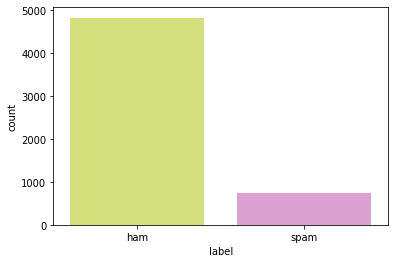

In [13]:
cols = ["#E1F16B", "#E598D8"]
fg = sns.countplot(x=df["label"], palette=cols)

**Balanced Dataset:** positive value와 negative value의 데이터셋의 수가 대충 비슷하면 Balanced Dataset

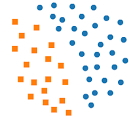

위의 이미지에서 오렌지 색을 positive, 파란 색은 negative value로 간주했을 때 둘의 데이터 수는 대충 비슷함.

<br />

**Imbalanced Dataset:** positive value와 negative value의 데이터셋의 수가 매우 다르다면 Imbalanced Dataset

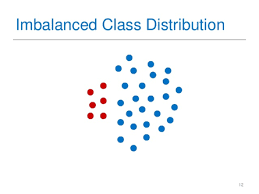

## Imbalanced Datasets의 문제점

- 데이터 셋이 한 쪽으로 치우친 채로 모델 학습을 진행 했을 경우에 트레이닝 모델은 매우 높은 정확도를 보여줄 수 있다.
- 하지만 실제의 데이터는 잘 맞추지 못한다.

## Imbalanced Dataset을 Balanced Dataset으로 바꾸는 방법

- 불균형한 데이터가 항상 나쁜 것은 아니며, 실제 데이터 세트에는 항상 어느 정도의 불균형이 있습니다.
- 즉, 불균형 수준이 상대적으로 낮으면 모형 성능에 큰 영향을 미치지 않습니다.

### 1 올바른 평가 메트릭 사용

- 1. **Confusion Matrix**
- 2. **Precision:**: 정밀도가 낮으면 잘못된 긍정의 수가 많다는 것을 나타냅니다.
- 3. **Recall:** 분류기의 완전성을 측정하는 척도이다. 리콜이 낮다는 것은 잘못된 부정의 수가 많다는 것을 나타냅니다.
- 4. **F1-Score:** 정밀도와 리콜의 가중 평균

### 2. Over-sampling (Up Sampling)

- 이 기술은 불균형 데이터 클래스를 수정하여 균형 잡힌 데이터 세트를 생성하는 데 사용됩니다. 데이터 양이 충분하지 않을 경우, 오버샘플링 방법은 희귀 표본의 크기를 증가시켜 균형을 맞추려고 합니다.
- 오버샘플링은 훈련 세트의 소수 클래스 멤버 수를 증가시킨다. 오버샘플링의 장점은 소수 및 다수 계층의 모든 관찰이 유지되기 때문에 원래 훈련 세트의 정보가 손실되지 않는다는 것이다. 반면에, 오버피팅 발생하기 쉽다.

### 3. Under-sampling (Down Sampling)

- 이 기술은 오버샘플링과 달리 풍부한 클래스의 크기를 줄임으로써 불균형 데이터 세트의 균형을 맞춘다. 클러스터 중심 및 Tomk 링크와 같은 분류 문제에 대한 다양한 방법이 있다. 군집 중심 방법은 표본의 군집을 K-평균 알고리듬의 군집 중심으로 대체하고, Tomek 링크 방법은 최소 거리인 가장 가까운 이웃이 모두 동일한 클래스가 될 때까지 클래스 간에 원치 않는 중복을 제거한다.
- 언더샘플링은 오버샘플링과 반대로 클래스 분포의 균형을 맞추기 위해 다수 표본의 수를 줄이는 것을 목표로 한다. 원래 데이터 집합에서 관찰을 제거하므로 유용한 정보가 삭제될 수 있습니다.

### 4. Feature selection

- 불균형 문제를 해결하기 위해, 우리는 양의 클래스와 음의 클래스 모두에 대해 상관 계수(CC) 및 승산비(OR)와 같은 단측 메트릭 또는 정보 이득(IG) 및 카이-제곱(CHI)과 같은 양측 메트릭 평가를 계산한다. 그런 다음 점수를 기반으로 각 클래스의 중요한 기능을 식별하고 이러한 기능의 조합을 사용하여 최종 기능 세트를 얻는다. 그런 다음 이 데이터를 사용하여 문제를 분류합니다.
- 이러한 기능을 식별하면 각 클래스에 대한 명확한 의사 결정 경계를 생성하는 데 도움이 된다. 이는 모델이 데이터를 더 정확하게 분류하는 데 도움이 됩니다. 이는 지능형 하위 샘플링 기능을 수행하고 잠재적으로 불균형 문제를 줄이는 데 도움이 된다.

### 5. Cost-Sensitive Learning Technique

- 비용 민감 학습(CSL)은 총 비용을 최소화하여 오분류 비용을 고려한다. 이 기술의 목표는 주로 예제를 알려진 클래스 집합으로 분류하는 높은 정확도를 추구하는 것이다. 그것은 실제 데이터 마이닝 애플리케이션을 포함한 머신 러닝 알고리듬에서 중요한 역할 중 하나로 작용하고 있다.

In [14]:
df['raw_text_len'] = df['raw_text'].apply(lambda x: len(x))
df[:5]

,label,raw_text,raw_text_len
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61


Text(0.5, 0, 'Message Length')

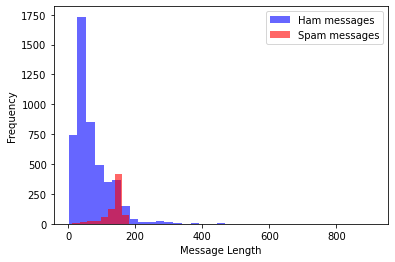

In [15]:
df[df['label'] == 'ham']['raw_text_len'].plot(bins=35,
                                              kind='hist',
                                              color='blue',
                                              label='Ham messages',
                                              alpha=0.6)
df[df['label'] == 'spam']['raw_text_len'].plot(kind='hist',
                                               color='red',
                                               label='Spam messages',
                                               alpha=0.6)

plt.legend()
plt.xlabel("Message Length")

In [16]:
reg_token = RegexpTokenizer('[\w]+')

In [17]:
# 불용언 처리
stop_words = stopwords.words('english')
stop_words.append('lt')
stop_words.append('gt')
lemmatizer = WordNetLemmatizer()

result = []
ham_texts = []
spam_texts = []
for index, (text, label) in enumerate(zip(df['raw_text'], df['label'])):
    word_tokens = reg_token.tokenize(text)
    result.append([])

    for word in word_tokens:
        if word not in stop_words:
            temp = lemmatizer.lemmatize(word)
            result[index].append(temp)

            if label == 'ham':
                ham_texts.append(temp.lower())
            else:
                spam_texts.append(temp.lower())

df['text'] = result
df['text'] = df['text'].str.join(' ')
df

,label,raw_text,raw_text_len,text
0,ham,"Go until jurong point, crazy.. Available only ...",111,Go jurong point crazy Available bugis n great ...
1,ham,Ok lar... Joking wif u oni...,29,Ok lar Joking wif u oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,Free entry 2 wkly comp win FA Cup final tkts 2...
3,ham,U dun say so early hor... U c already then say...,49,U dun say early hor U c already say
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,Nah I think go usf life around though
...,...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,161,This 2nd time tried 2 contact u U å 750 Pound ...
5568,ham,Will Ì_ b going to esplanade fr home?,37,Will Ì_ b going esplanade fr home
5569,ham,"Pity, * was in mood for that. So...any other s...",57,Pity mood So suggestion
5570,ham,The guy did some bitching but I acted like i'd...,125,The guy bitching I acted like interested buyin...


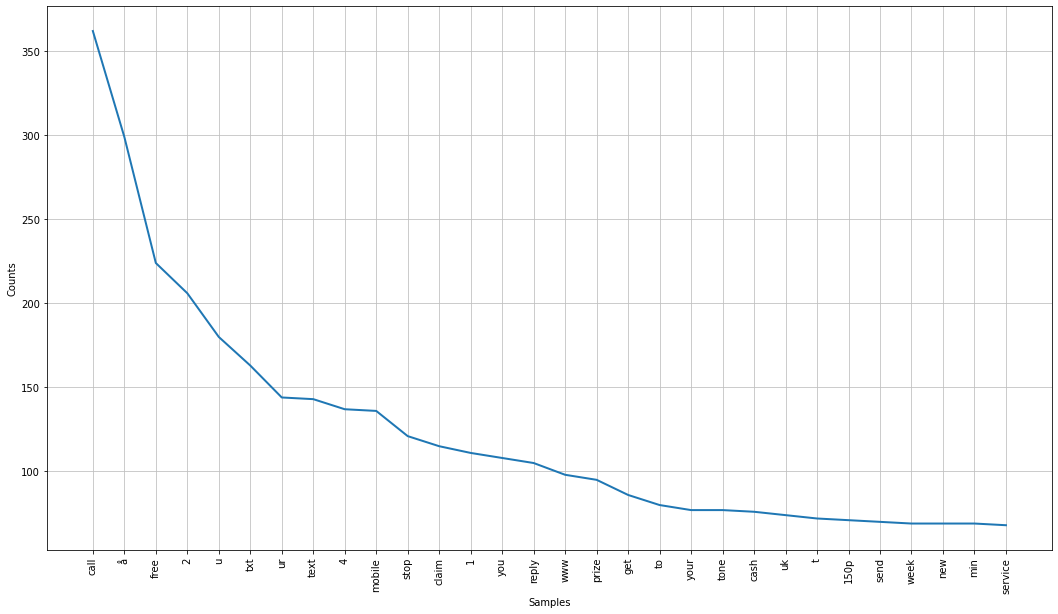

<AxesSubplot:xlabel='Samples', ylabel='Counts'>

In [18]:
# spam SMS 많이 등장한 token 상위 30개
# call, free, www, prize, cash, win, urgent, now...
plt.figure(figsize=(18, 10))
Text(spam_texts).plot(30)

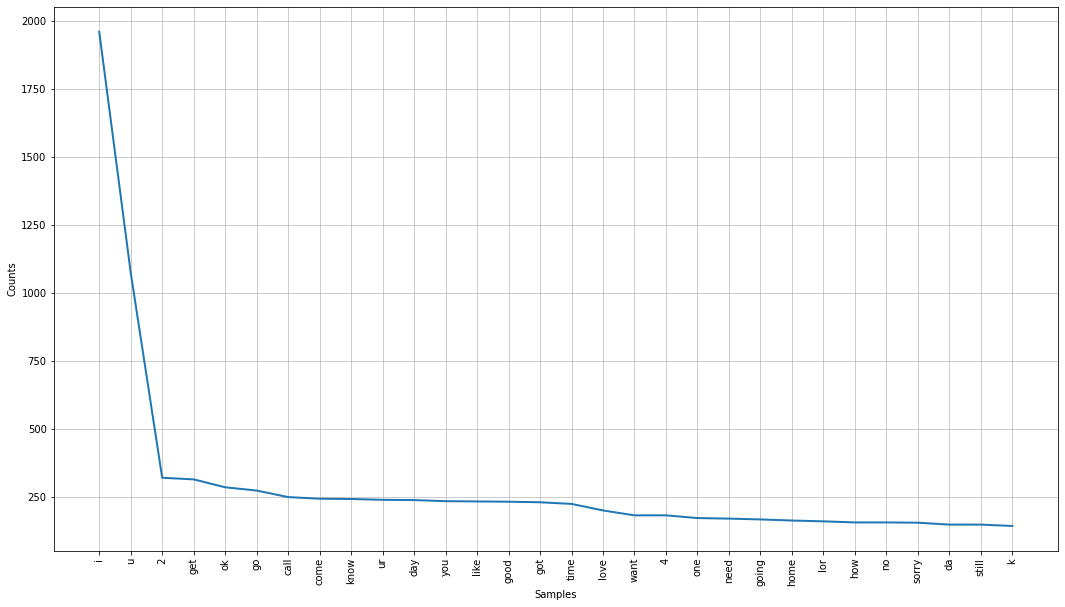

<AxesSubplot:xlabel='Samples', ylabel='Counts'>

In [19]:
# ham SMS 많이 등장한 token 상위 30개
# go, good, come, love, home, want, sorry...
plt.figure(figsize=(18, 10))
Text(ham_texts).plot(30)

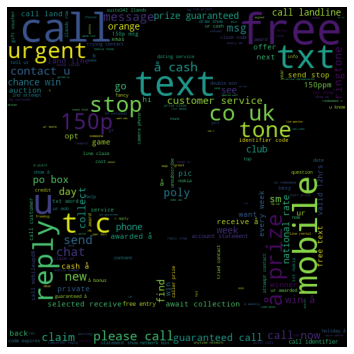

In [20]:
# spam sms 시각화
spam_mask = np.array(Image.open('images/spam.png'))
wc = WordCloud(
    background_color='black',
    mask=spam_mask,
).generate(' '.join(spam_texts))

plt.figure(figsize=(13, 5))
plt.imshow(wc)
plt.axis('off')
plt.tight_layout(pad=1)
plt.show()

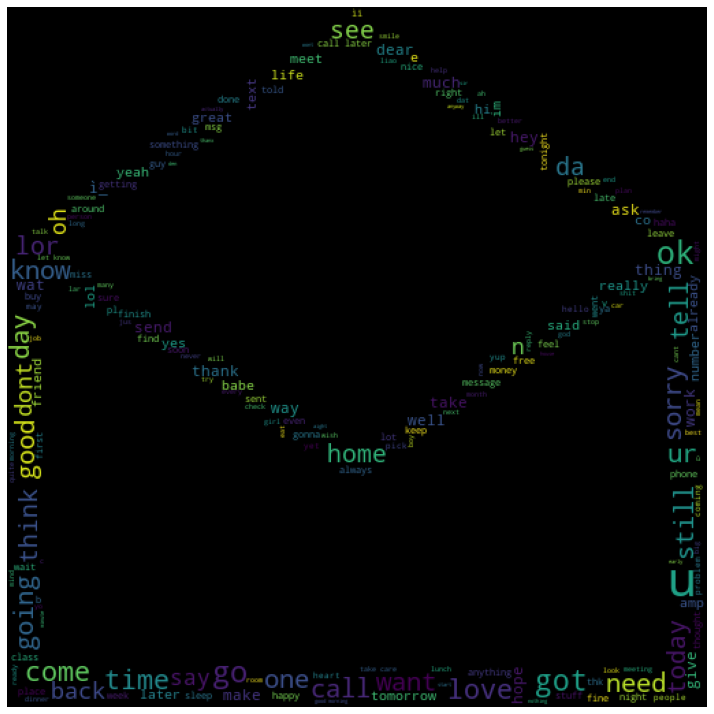

In [21]:
# ham sms 시각화
mail_mask = np.array(Image.open('images/open-mail.png'))
wc = WordCloud(
    background_color='black',
    mask=mail_mask,
).generate(' '.join(ham_texts))

plt.figure(figsize=(18, 10))
plt.imshow(wc)
plt.axis('off')
plt.tight_layout(pad=1)
plt.show()

In [22]:
df['spam'] = df['label'].apply(lambda x: 1 if x == 'spam' else 0)
df[:5]

,label,raw_text,raw_text_len,text,spam
0,ham,"Go until jurong point, crazy.. Available only ...",111,Go jurong point crazy Available bugis n great ...,0
1,ham,Ok lar... Joking wif u oni...,29,Ok lar Joking wif u oni,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,Free entry 2 wkly comp win FA Cup final tkts 2...,1
3,ham,U dun say so early hor... U c already then say...,49,U dun say early hor U c already say,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,Nah I think go usf life around though,0


In [23]:
X_train, X_test, y_train, y_test = train_test_split(df['text'],
                                                    df['spam'],
                                                    test_size=0.2,
                                                    random_state=777)

In [24]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(4457,)
(1115,)
(4457,)
(1115,)


In [25]:
cv = CountVectorizer(stop_words='english')
cv.fit_transform(X_train)
X_train_dtm = cv.transform(X_train)
X_test_dtm = cv.transform(X_test)

In [26]:
tfidf_transformer = TfidfTransformer()
tfidf_transformer.fit(X_train_dtm)
X_train_tfidf = tfidf_transformer.transform(X_train_dtm)
X_test_tfidf = tfidf_transformer.transform(X_test_dtm)

In [27]:
classifiers = [
    MultinomialNB(),
    RandomForestClassifier(),
    KNeighborsClassifier(),
    SVC()
]

for clsf in classifiers:
    clsf.fit(X_train_tfidf, y_train)

In [28]:
accuracy_list = []
precision_list = []
recall_list = []
f1_score_list = []
y_predict_list = []

for i in classifiers:
    y_predict = i.predict(X_test_tfidf)

    _accuracy = accuracy_score(y_test, y_predict)
    _precision = precision_score(y_test, y_predict)
    _reacll = recall_score(y_test, y_predict)
    _f1_score = f1_score(y_test, y_predict)

    y_predict_list.append(y_predict)
    accuracy_list.append(_accuracy)
    precision_list.append(_precision)
    recall_list.append(_reacll)
    f1_score_list.append(_f1_score)

In [29]:
data = {
    'Accuracy': accuracy_list,
    'Precision': precision_list,
    'Recall': recall_list,
    'F1score': f1_score_list,
}

df_results = pd.DataFrame(
    data, index=["NaiveBayes", "RandomForest", "KNeighbours", "SVC"])
df_results

,Accuracy,Precision,Recall,F1score
NaiveBayes,0.962332,1.000000,0.718121,0.835938
RandomForest,0.977578,0.976923,0.852349,0.910394
KNeighbours,0.911211,1.000000,0.335570,0.502513
SVC,0.977578,0.976923,0.852349,0.910394


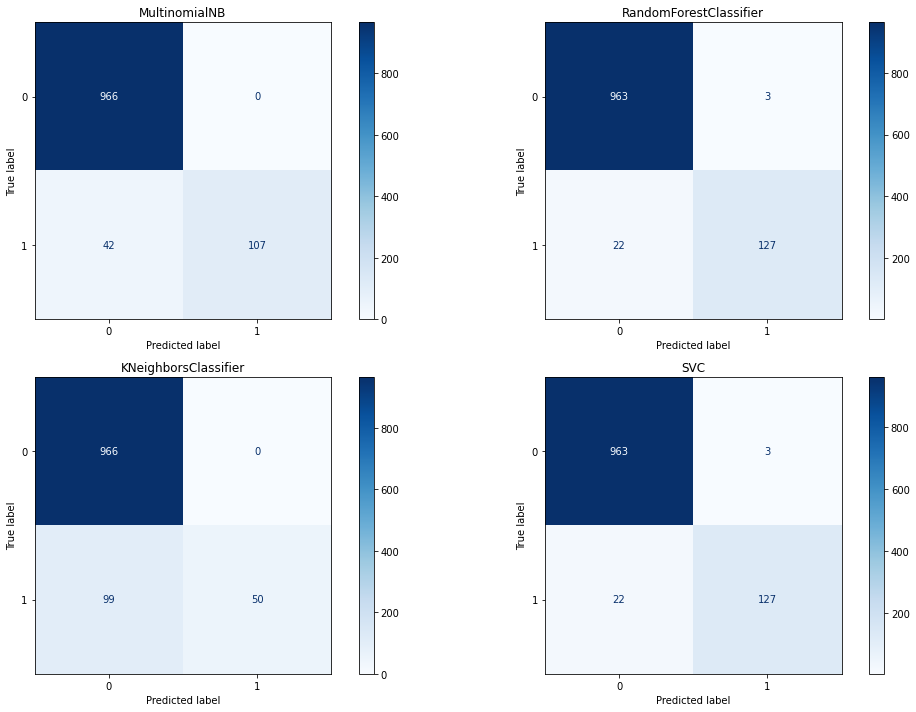

In [30]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))

for clss, ax in zip(classifiers, axes.flatten()):
    plot_confusion_matrix(clss, X_test_tfidf, y_test, ax=ax, cmap='Blues')
    ax.title.set_text(type(clss).__name__)

plt.tight_layout()
plt.show()